<h1 align="center"><b>Cat vs. Dog classification</b></h1>
<img src="CatVSDog.jpeg" alt="catVSdog" width="300" height="200" align="center">

<h1>Import necessary Libraries</h1>

In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import random

<h1>Prepare Training Data</h1>

In [2]:
#function to extract train and test folders
def extract(source_path, target_path):
    zip_ref = zipfile.ZipFile(source_path,'r')
    zip_ref.extractall(target_path)
    zip_ref.close()

In [3]:
extract('../input/dogs-vs-cats/test1.zip','/kaggle/working/')
extract('../input/dogs-vs-cats/train.zip','/kaggle/working/')

In [4]:
#creating a pandas dataframe with two columns filename and category to store class of each image
fnames = os.listdir("/kaggle/working/train")
categories = []
for name in fnames:
    category = name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': fnames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,dog.992.jpg,1
1,dog.3524.jpg,1
2,dog.10604.jpg,1
3,dog.10325.jpg,1
4,cat.4857.jpg,0


<b>Print images from training folder</b>

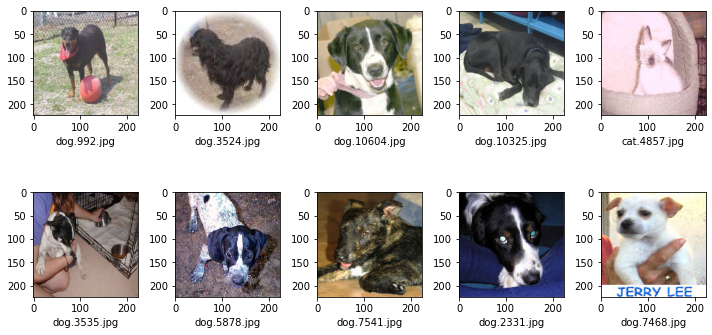

In [6]:
sample_test = df.head(10)
sample_test.head()
plt.figure(figsize=(10, 20))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/kaggle/working/train/"+filename, target_size=(224,224))
    plt.subplot(8, 5, index+1)
    plt.imshow(img)
    plt.xlabel(filename)
plt.tight_layout()
plt.show()

In [7]:
#replace class 0 by cat and class 1 by dog
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [8]:
#Split train dataset into train and validation dataset
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [9]:
#defining constants
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20

<h1>Training Generator</h1>

<b>Keras ImageDataGenerator<b> class is used to perform data augmentation.<br>
<br>
Following are some functions of ImageDataGenerator: -
> 1. Accepting a batch of images used for training. <br>
> 2. Taking this batch and applying a series of random transformations to each image in the batch (including random rotation,    resizing, shearing, etc.).<br>
> 3. Replacing the original batch with the new, randomly transformed batch.<br>

In [10]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)
 
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


<h1>Validation Generator</h1>

In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


<h1>Model Creation</h1>


In [12]:
#model design
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

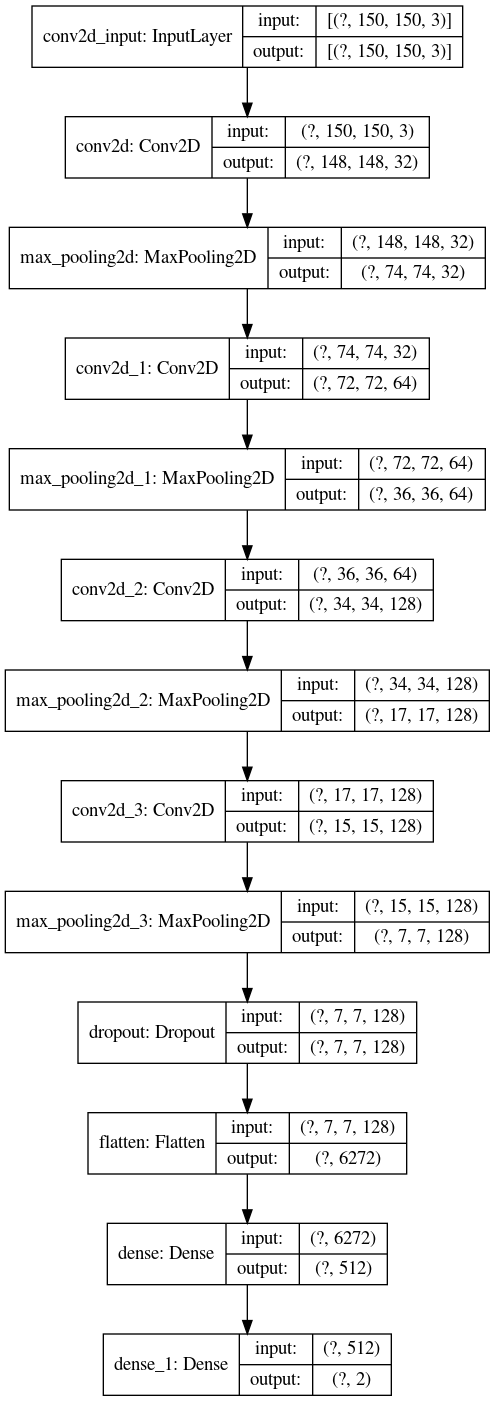

In [14]:
#plot model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<h1>Model compilation and training</h1>

In [15]:
#model compile
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [16]:
#fit model
history = model.fit(
            train_generator, 
            epochs=20,
            validation_data=validation_generator,
            validation_steps=total_validate//batch_size,
            steps_per_epoch=total_train//batch_size)

Epoch 1/20
1000/1000 [==============================] - 178s 178ms/step - loss: 0.6614 - accuracy: 0.5911 - val_loss: 0.5915 - val_accuracy: 0.6756
Epoch 2/20
1000/1000 [==============================] - 178s 178ms/step - loss: 0.5963 - accuracy: 0.6779 - val_loss: 0.5143 - val_accuracy: 0.7426
Epoch 3/20
1000/1000 [==============================] - 176s 176ms/step - loss: 0.5632 - accuracy: 0.7113 - val_loss: 0.5221 - val_accuracy: 0.7422
Epoch 4/20
1000/1000 [==============================] - 175s 175ms/step - loss: 0.5383 - accuracy: 0.7276 - val_loss: 0.4750 - val_accuracy: 0.7754
Epoch 5/20
1000/1000 [==============================] - 179s 179ms/step - loss: 0.5185 - accuracy: 0.7452 - val_loss: 0.4570 - val_accuracy: 0.7842
Epoch 6/20
1000/1000 [==============================] - 179s 179ms/step - loss: 0.5010 - accuracy: 0.7556 - val_loss: 0.3970 - val_accuracy: 0.8250
Epoch 7/20
1000/1000 [==============================] - 179s 179ms/step - loss: 0.4866 - accuracy: 0.7689 - val_

In [17]:
#save mode;
model.save_weights("model.h5")

<h1>Visualize Training</h1.

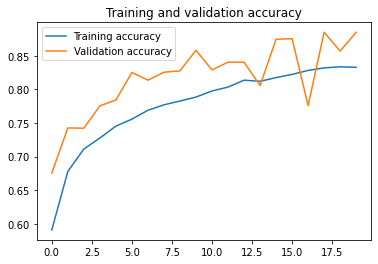

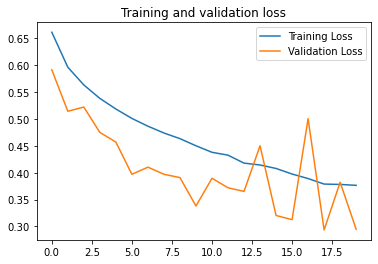

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc,  label='Training accuracy')
plt.plot(epochs, val_acc,  label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss,label='Training Loss')
plt.plot(epochs, val_loss,label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<h1>Prepare testing data</h1>

In [19]:
#load test data
test_fnames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame({
    'filename': test_fnames
})

<h1>Test Generator</h1>

In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


<h1>Predicting test images</h1>

In [21]:
total_test = test_df.shape[0]
predict = model.predict_generator(test_generator, steps=total_test//batch_size)

In [22]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df['category'] = test_df['category'].replace({1: 'dog', 0: 'cat'})

In [23]:
test_df.head()

,filename,category
0,5355.jpg,cat
1,11826.jpg,dog
2,4516.jpg,dog
3,3903.jpg,cat
4,7457.jpg,dog


Prediction of test images


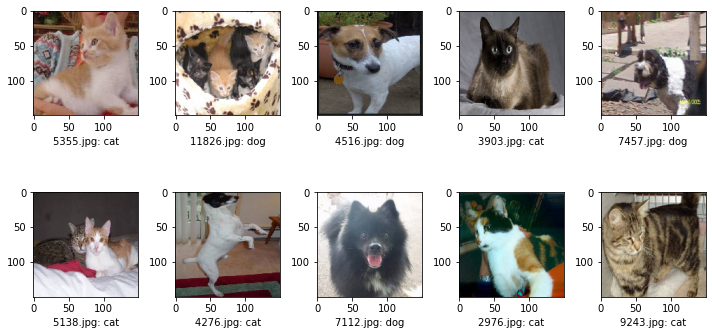

In [25]:
sample_test = test_df.head(10)
sample_test.head()
plt.figure(figsize=(10, 20))
print("Prediction of test images")
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/kaggle/working/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(8, 5, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ': ' + "{}".format(category))
plt.tight_layout()
plt.show()